In [1]:
%matplotlib inline

In [2]:
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skimage.io as io
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from nilearn.input_data import NiftiMasker
import seaborn as sns
import scipy.stats as stats

In [3]:
mask_img = nb.load('/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_200um.nii.gz')
mask = mask_img.get_data()
aff = mask_img.affine
hdr = mask_img.header

In [4]:
df = pd.read_csv("/home/julia/data/gradients/genes/gene_list_full.csv")
df = df[df['acronym']!="FALSE"]

### Make a mask that has data in most gene maps

In [13]:
ids = list(df['id'])
gene_mask = np.zeros(mask.shape)
n_maps = 0
for n in range(len(ids)):
    try:
        # load and save as nifti
        gene = np.swapaxes(io.imread('/home/julia/data/gradients/genes/energy/%s/energy.mhd'% ids[n],
                                      plugin='simpleitk'), 
                            0,2)[:-1,:-1,:-1]
        nb.save(nb.Nifti1Image(gene, aff, hdr), '/home/julia/data/gradients/genes/energy/%s/energy.nii.gz'% ids[n])
        
        # create a mask that has data in all maps
        gene_mask[np.where(gene >= 1)] += 1
        
        n_maps += 1

    except RuntimeError:
        pass
gene_mask[mask==0] = 0

In [17]:
gene_mask_thr = np.zeros(mask.shape)
gene_mask_thr[gene_mask >= (n_maps/2)] = 1
nb.save(nb.Nifti1Image(gene_mask_thr, aff, hdr), '/home/julia/data/gradients/genes/gene_mask.nii.gz')

In [20]:
np.where(mask==1)[0].shape[0] - np.where(gene_mask_thr==1)[0].shape[0]

4230

### Create a gene matrix

In [26]:
masker = NiftiMasker(mask_img=nb.Nifti1Image(gene_mask_thr, aff, hdr), 
                     standardize=False, smoothing_fwhm=0.45)

In [29]:
gene_matrix = np.zeros((np.where(gene_mask_thr==1)[0].shape[0], len(df)))
ids = list(df['id'])
for n in range(len(ids)):
    try:
        # load and save as nifti
        gene = nb.load('/home/julia/data/gradients/genes/energy/%s/energy.nii.gz'% ids[n]).get_data()
        
        # smooth and add to gene matrix            
        gene_matrix[:,n] = masker.fit_transform(nb.Nifti1Image(gene, aff, hdr))

    except FileNotFoundError:
        gene_matrix[:,n] = np.nan

In [30]:
np.save('/home/julia/data/gradients/genes/gene_matrix.npy', gene_matrix)
# gene_matrix = np.load('/home/julia/data/gradients/genes/gene_matrix.npy')

## !!! Normalize expression data (see Fulcher, Goulas) ##

In [31]:
df = pd.DataFrame(data=gene_matrix, columns=ids)
df_small = df.dropna(axis=1)

In [34]:
# Standardizing the features & run PCA
x = StandardScaler().fit_transform(df_small.loc[:,:])
pca = PCA()
pcs = pca.fit_transform(x)

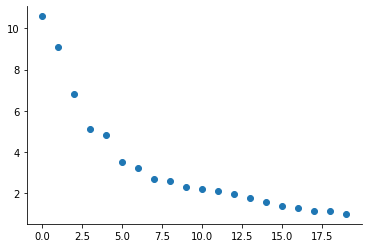

In [35]:
plt.plot(pca.explained_variance_ratio_[:20]*100, 'o')
sns.despine()

In [36]:
np.save('/home/julia/data/gradients/genes/pca_components.npy', pcs)

### Correlate first 6 PCAs with first 6 Gradients

In [38]:
gradients = nb.load('/home/julia/data/gradients/results/embedding_vol/embed.nii.gz').get_data()
for g in range(6):
    gradient =  gradients[:,:,:,g]
    for p in range(6):
        r = stats.spearmanr(gradient[gene_mask_thr==1], pcs[:,p])
        if np.abs(r[0]) > 0.3:
            print('Gradient %i, PCA %i:' %(g,p), r)

Gradient 0, PCA 2: SpearmanrResult(correlation=0.3980257743878758, pvalue=0.0)
Gradient 0, PCA 3: SpearmanrResult(correlation=0.36542420003614834, pvalue=0.0)
Gradient 0, PCA 4: SpearmanrResult(correlation=-0.3830228998067505, pvalue=0.0)
Gradient 1, PCA 4: SpearmanrResult(correlation=0.30681893373947444, pvalue=1.4215599768462748e-242)
Gradient 2, PCA 0: SpearmanrResult(correlation=-0.47627835579917277, pvalue=0.0)
Gradient 2, PCA 2: SpearmanrResult(correlation=-0.6228465798132243, pvalue=0.0)
Gradient 4, PCA 0: SpearmanrResult(correlation=0.33123438947042144, pvalue=9.306860782904315e-285)
Gradient 4, PCA 1: SpearmanrResult(correlation=0.6190798798653486, pvalue=0.0)


### Save first six PCAs as images

In [47]:
for p in range(6):
    revolume = masker.inverse_transform(pcs[:,p])
    revolume.to_filename('/home/julia/data/gradients/genes/pca_%i.nii.gz' %p)